In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [12]:
returns = pd.read_pickle("../Data/returns.pkl")
returns = returns.iloc[1:]

In [13]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [56]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [66]:
def format_investable(df, n_in=1, n_out=1):
    "Takes investable dataframe and formats it to have all stock returns at time t-1\
    (the features) and all corresponding stock returns at time t (the targets)\
    n_in is the number of past returns we want to use, n_out is the number of future \
    returns we want to predict"
    
    n_vars = df.shape[1]
    
    cols = []
    input_col_names = df.add_suffix(' (t-1)').columns
    forecast_col_names = df.add_suffix(' (t)').columns
    names = input_col_names.append(forecast_col_names)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(i))
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop the first row (it contains NaNs)
    agg.dropna(inplace=True)
    
    return agg

In [67]:
a = get_investable(pd.to_datetime('2020-05-22'), 20)
a

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,1.194822,0.951510,-0.505222,-0.482703,-0.296359,1.822412,-0.556607,0.277681,0.643838,0.740319,...,-0.071324,-1.295312,-0.126968,-5.856833,-0.128433,2.462057,-0.566286,-0.034953,2.631579,-0.924499
2020-05-21,0.333000,-3.085653,-1.776480,-2.509804,-0.211238,-0.488746,-0.991954,2.746077,-0.745544,-0.650636,...,3.275705,1.476286,-0.379459,-6.607449,-3.374541,10.613691,-4.546332,1.265375,4.576000,-0.358240
2020-05-20,2.119701,1.658554,1.597255,5.809129,3.227213,0.790770,3.976622,1.483894,1.944817,1.522114,...,0.777259,0.934394,0.739042,-4.281026,3.815470,12.958281,4.604200,2.624410,8.657858,3.520132
2020-05-19,-2.270965,1.612017,-1.222013,-2.350081,-6.617797,-3.430145,-1.300758,-2.882250,-0.577851,-2.737430,...,-0.239589,-0.690671,1.552795,4.067060,-1.469583,6.651685,-2.968551,-1.157885,3.453237,-1.106066
2020-05-18,0.422739,0.719557,4.784248,14.577530,11.436351,1.848782,7.528582,7.480166,2.356115,4.923798,...,2.955555,1.809315,9.152542,10.355460,6.118854,14.987080,12.846877,6.408787,19.775959,1.160120
2020-05-15,-2.059272,-0.568703,1.072600,-4.266667,3.039514,0.422535,-1.897148,2.756211,-0.591200,-0.117096,...,2.416058,-0.517844,1.490826,2.448227,-3.956011,9.198646,-3.355059,4.003179,4.880253,4.177914
2020-05-14,-0.412326,4.465312,-0.097414,5.633803,0.967894,0.476007,7.407407,3.205128,0.614334,0.945626,...,0.623960,1.563922,1.483852,-0.852619,0.590650,7.134220,0.601956,2.829418,9.122288,1.311455
2020-05-13,-1.748401,-2.938988,-1.919569,-4.226619,-5.446429,-0.231036,-6.146259,-5.988701,-1.207411,-2.590674,...,-2.360215,-2.279438,-3.183099,-3.036950,-4.639618,-6.816901,-5.390013,-1.834954,-12.510785,-0.043489
2020-05-12,-2.362860,-3.552207,-1.035802,-5.442177,-4.943773,-1.591512,-2.566507,-3.629764,-1.142821,-1.947502,...,-2.696175,-0.231730,-4.338453,-0.520309,-0.475059,-4.876742,-4.124415,-3.967260,12.415131,-1.997077


In [118]:
format_investable(a)

,916328 (t-1),936365 (t-1),905271 (t-1),905113 (t-1),905802 (t-1),905425 (t-1),906156 (t-1),916305 (t-1),992816 (t-1),921093 (t-1),...,311917 (t),69568X (t),543755 (t),77463M (t),29235J (t),131745 (t),69487D (t),68157P (t),9110RA (t),292703 (t)
date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,0.333000,-3.085653,-1.776480,-2.509804,-0.211238,-0.488746,-0.991954,2.746077,-0.745544,-0.650636,...,-0.071324,-1.295312,-0.126968,-5.856833,-0.128433,2.462057,-0.566286,-0.034953,2.631579,-0.924499
2020-05-21,2.119701,1.658554,1.597255,5.809129,3.227213,0.790770,3.976622,1.483894,1.944817,1.522114,...,3.275705,1.476286,-0.379459,-6.607449,-3.374541,10.613691,-4.546332,1.265375,4.576000,-0.358240
2020-05-20,-2.270965,1.612017,-1.222013,-2.350081,-6.617797,-3.430145,-1.300758,-2.882250,-0.577851,-2.737430,...,0.777259,0.934394,0.739042,-4.281026,3.815470,12.958281,4.604200,2.624410,8.657858,3.520132
2020-05-19,0.422739,0.719557,4.784248,14.577530,11.436351,1.848782,7.528582,7.480166,2.356115,4.923798,...,-0.239589,-0.690671,1.552795,4.067060,-1.469583,6.651685,-2.968551,-1.157885,3.453237,-1.106066
2020-05-18,-2.059272,-0.568703,1.072600,-4.266667,3.039514,0.422535,-1.897148,2.756211,-0.591200,-0.117096,...,2.955555,1.809315,9.152542,10.355460,6.118854,14.987080,12.846877,6.408787,19.775959,1.160120
2020-05-15,-0.412326,4.465312,-0.097414,5.633803,0.967894,0.476007,7.407407,3.205128,0.614334,0.945626,...,2.416058,-0.517844,1.490826,2.448227,-3.956011,9.198646,-3.355059,4.003179,4.880253,4.177914
2020-05-14,-1.748401,-2.938988,-1.919569,-4.226619,-5.446429,-0.231036,-6.146259,-5.988701,-1.207411,-2.590674,...,0.623960,1.563922,1.483852,-0.852619,0.590650,7.134220,0.601956,2.829418,9.122288,1.311455
2020-05-13,-2.362860,-3.552207,-1.035802,-5.442177,-4.943773,-1.591512,-2.566507,-3.629764,-1.142821,-1.947502,...,-2.360215,-2.279438,-3.183099,-3.036950,-4.639618,-6.816901,-5.390013,-1.834954,-12.510785,-0.043489
2020-05-12,2.529349,4.794134,-0.346925,-6.814580,-2.784653,-0.864012,-4.659218,-0.361664,1.573665,-2.638087,...,-2.696175,-0.231730,-4.338453,-0.520309,-0.475059,-4.876742,-4.124415,-3.967260,12.415131,-1.997077


In [55]:
def reshape_investable(df):
    "Takes formatted investable and reshapes inputs it into 3D array [samples, timesteps, features]"
    
    # select columns ending with ' (t-1)' for features
    # and columns ending with ' (t)' for targets
    X_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t-1)')]
    y_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t)')]

    X_train = df[X_col].iloc[1:,:].values
    y_train = df[y_col].iloc[1:,:].values
    
    X_test = df[X_col].iloc[0:1,:].values
    y_test = df[y_col].iloc[0:1,:].values
    
    #reshape
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, y_train, X_test, y_test

In [95]:
def portfolio_return(df, n):
    "Takes dataframe with predicted and actual returns and outputs and what the equally-weighted\
    portfolio with n long and n short stocks would have actually earned"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return_a = topn_p['actual return'].mean() - botn_p['actual return'].mean()
    #return_long = topn_p['actual return'].sum()
    #return_short = botn_p['actual return'].sum()
    
    return return_a #, return_long, return_short

In [18]:
def topn_bottomn(df, n):
    "Takes dataframe with predicted and actual returns and outputs a list of predicted top n\
    stocks and another list of bottom n stocks"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return topn_p, botn_p

In [102]:
def LSTM_pipeline(n_stocks, lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    date_range = returns.index[2527:2652]
    
    all_returns['date'] = date_range
    all_returns['date'] = all_returns['date'].astype('datetime64[ns]')
    all_returns.set_index('date', inplace = True)
    
    count = 0
    for t in date_range:
        t = pd.to_datetime(t)
        
        #get investable
        investable = get_investable(t, lookback)
        #format as features and targets
        f_investable = format_investable(investable)
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        df = pd.DataFrame(index = col, data = yhat.T)
        df = df.rename(columns = {0: 'pred return'})
        df['actual return'] = y_test.T

        #calculate portfolio return
        return_t = portfolio_return(df, 5)

        #add return to dataframe
        all_returns.loc[t]['portfolio return'] = return_t
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
        print(f'{((count)/len(date_range))*100} % complete')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

## 125 time periods from 2000-01-03 to 2000-06-30

In [103]:
df = LSTM_pipeline(5, 504)

124 time periods remaining...
0.8 % complete
123 time periods remaining...
1.6 % complete
122 time periods remaining...
2.4 % complete
121 time periods remaining...
3.2 % complete
120 time periods remaining...
4.0 % complete
119 time periods remaining...
4.8 % complete
118 time periods remaining...
5.6000000000000005 % complete
117 time periods remaining...
6.4 % complete
116 time periods remaining...
7.199999999999999 % complete
115 time periods remaining...
8.0 % complete
114 time periods remaining...
8.799999999999999 % complete
113 time periods remaining...
9.6 % complete
112 time periods remaining...
10.4 % complete
111 time periods remaining...
11.200000000000001 % complete
110 time periods remaining...
12.0 % complete
109 time periods remaining...
12.8 % complete
108 time periods remaining...
13.600000000000001 % complete
107 time periods remaining...
14.399999999999999 % complete
106 time periods remaining...
15.2 % complete
105 time periods remaining...
16.0 % complete
104 tim

In [104]:
df

,portfolio return
date,
2000-01-03,-6.847491
2000-01-04,-1.705230
2000-01-05,-1.284685
2000-01-06,-2.120570
2000-01-07,1.409214
...,...
2000-06-23,2.482295
2000-06-26,0.020899
2000-06-27,-1.784426


In [105]:
df['portfolio return'] = df['portfolio return'].astype(float)

In [106]:
monthly_avg = df.resample('M').mean()
monthly_avg

,portfolio return
date,
2000-01-31,-0.344316
2000-02-29,0.878360
2000-03-31,1.255261
2000-04-30,1.217931
2000-05-31,1.295962
2000-06-30,-0.952108


In [107]:
total_avg = df['portfolio return'].mean()
print(f'Total average return is: {total_avg:.2f} %')

Total average return is: 0.57 %


In [108]:
data = df.copy(deep = True)
data['30_day_avg'] = data['portfolio return'].rolling(30).mean()
data.dropna(inplace = True)

In [109]:
data.reset_index(inplace = True)

In [110]:
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

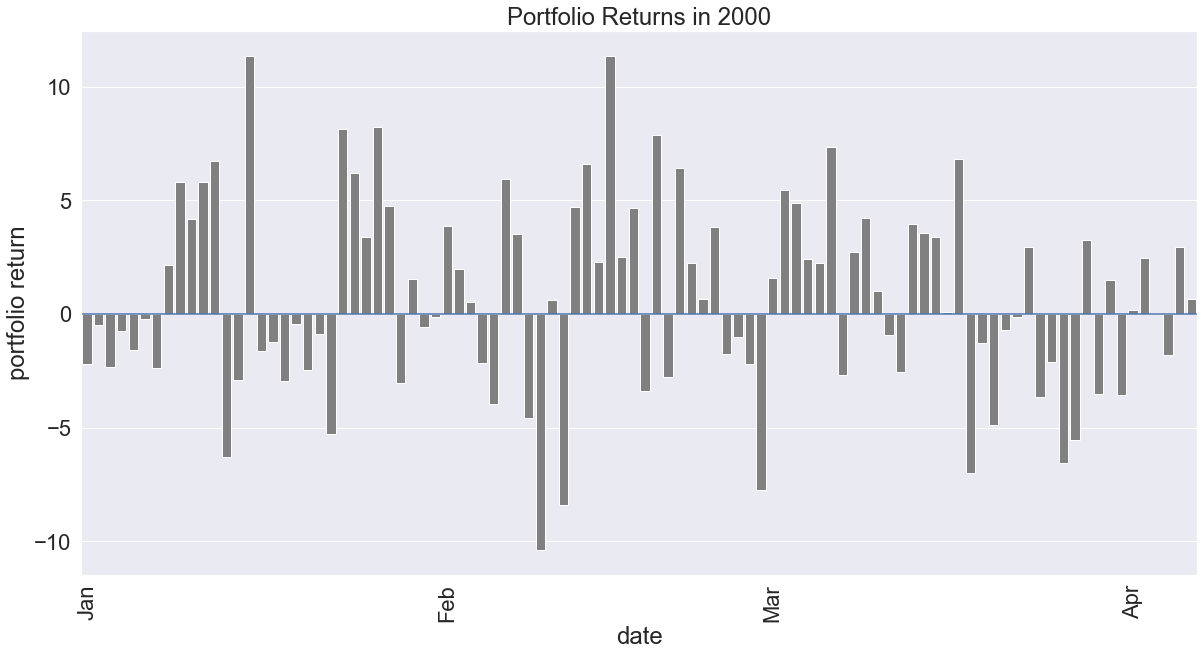

In [111]:
fig, axes = plt.subplots(figsize=(20,10))
sns.barplot(x = 'date', y = 'portfolio return', data = data, color = 'grey')

axes.xaxis.set_major_locator(mdates.MonthLocator())
myFmt = mdates.DateFormatter("%b")
axes.xaxis.set_major_formatter(myFmt)
#axes.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns in 2000')

sns.set(font_scale=2)
plt.axhline(0)

plt.show()

## Comparison to S&P

In [86]:
sp_actual = pd.read_csv('../Data/S&P 500 Historical Data (3).csv', usecols = ['Date', 'Change %'], index_col = 'Date', parse_dates = True)

In [87]:
sp_actual

,Change %
Date,
Dec-00,0.41%
Nov-00,-8.01%
Oct-00,-0.49%
Sep-00,-5.35%
Aug-00,6.07%
Jul-00,-1.63%
Jun-00,2.39%
May-00,-2.19%
Apr-00,-3.08%


In [112]:
monthly_avg.index = monthly_avg.index.strftime('%b-%y')
monthly_avg

,portfolio return
date,
Jan-00,-0.344316
Feb-00,0.878360
Mar-00,1.255261
Apr-00,1.217931
May-00,1.295962
Jun-00,-0.952108


In [113]:
strategy_vs_sp = monthly_avg.merge(sp_actual, left_index = True, right_index = True)
strategy_vs_sp['Change %'] = strategy_vs_sp['Change %'].apply(lambda x: x.strip('%'))

In [114]:
strategy_vs_sp['Change %'] = strategy_vs_sp['Change %'].astype(float)
strategy_vs_sp = strategy_vs_sp.rename(columns = {'Change %': 's&p return'})

In [115]:
strategy_vs_sp

,portfolio return,s&p return
Jan-00,-0.344316,-5.09
Feb-00,0.878360,-2.01
Mar-00,1.255261,9.67
Apr-00,1.217931,-3.08
May-00,1.295962,-2.19
Jun-00,-0.952108,2.39


<AxesSubplot:xlabel='Date', ylabel='Return (%)'>

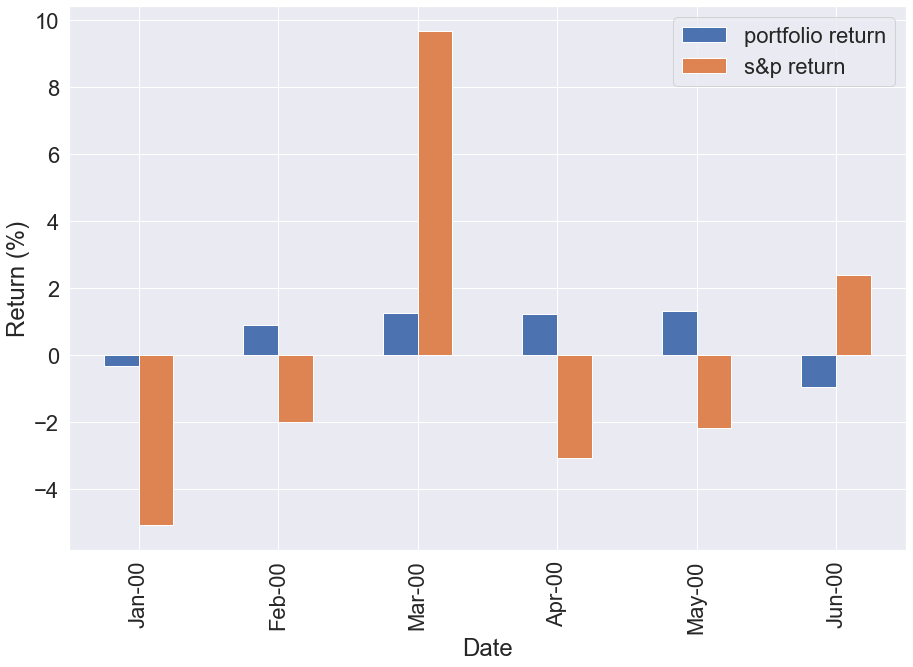

In [116]:
strategy_vs_sp.plot(kind = 'bar', xlabel = 'Date', ylabel = 'Return (%)', figsize=(15,10))

## Comparison to Simple RNN

In [93]:
def LSTM_pipeline_comp(n_stocks, lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    date_range = returns.index[7888:7911]
    
    all_returns['date'] = date_range
    all_returns['date'] = all_returns['date'].astype('datetime64[ns]')
    all_returns.set_index('date', inplace = True)
    
    count = 0
    for t in date_range:
        t = pd.to_datetime(t)
        
        #get investable
        investable = get_investable(t, lookback)
        #format as features and targets
        f_investable = format_investable(investable)
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        df = pd.DataFrame(index = col, data = yhat.T)
        df = df.rename(columns = {0: 'pred return'})
        df['actual return'] = y_test.T

        #calculate portfolio return
        return_t = portfolio_return(df, 5)

        #add return to dataframe
        all_returns.loc[t]['portfolio return'] = return_t
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

In [94]:
df_rnn = LSTM_pipeline_comp(5,160)

22 time periods remaining...
21 time periods remaining...
20 time periods remaining...
19 time periods remaining...
18 time periods remaining...
17 time periods remaining...
16 time periods remaining...
15 time periods remaining...
14 time periods remaining...
13 time periods remaining...
12 time periods remaining...
11 time periods remaining...
10 time periods remaining...
9 time periods remaining...
8 time periods remaining...
7 time periods remaining...
6 time periods remaining...
5 time periods remaining...
4 time periods remaining...
3 time periods remaining...
2 time periods remaining...
1 time periods remaining...
0 time periods remaining...


In [259]:
df_rnn['portfolio return'] = df_rnn['portfolio return'].astype(float)

In [258]:
monthly_avg_rnn = df_rnn.resample('M').mean()
monthly_avg_rnn

,portfolio return
date,
2021-04-30,-0.523440
2021-05-31,4.896529


In [257]:
total_avg = df_rnn['portfolio return'].mean()
print(f'Total average return is: {total_avg:.2f} %')

Total average return is: 3.72 %


In [62]:
returns.index.get_loc('2000')

slice(2527, 2779, None)